In [66]:
import requests
import pandas as pd
import numpy as np

In [69]:
# Binance API endpoint for klines (candlestick data)
url = 'https://api.binance.com/api/v3/klines'

# Parameters for the API request
symbol = 'BTCUSDT'  # Bitcoin symbol on Binance
interval = '15m'  # 15-minute interval (adjust as needed)
limit = 10000000000000 # Number of data points to retrieve (max: 1000)

# API request parameters
params = {
    'symbol': symbol,
    'interval': interval,
    'limit': limit
}

# Send the API request
response = requests.get(url, params=params)

# Parse the response JSON into a pandas DataFrame
data = pd.DataFrame(response.json(),
                    columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
                             'quote_asset_volume', 'num_trades', 'taker_buy_base_asset_volume',
                             'taker_buy_quote_asset_volume', 'ignored'])

# Convert the timestamp to a readable format
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

# Shift the open price by one row to get the next interval's opening price
data['next_open'] = data['open'].shift(-1)

# Display the retrieved data
print(data)

              timestamp            open            high             low  \
0   2023-05-26 04:00:00  26435.14000000  26450.85000000  26432.49000000   
1   2023-05-26 04:15:00  26444.61000000  26447.02000000  26420.15000000   
2   2023-05-26 04:30:00  26423.46000000  26426.85000000  26410.03000000   
3   2023-05-26 04:45:00  26420.80000000  26434.54000000  26420.79000000   
4   2023-05-26 05:00:00  26426.44000000  26432.10000000  26400.00000000   
..                  ...             ...             ...             ...   
995 2023-06-05 12:45:00  26702.93000000  26719.90000000  26654.39000000   
996 2023-06-05 13:00:00  26690.76000000  26732.86000000  26640.00000000   
997 2023-06-05 13:15:00  26724.37000000  26732.66000000  26685.51000000   
998 2023-06-05 13:30:00  26721.64000000  26763.95000000  26721.63000000   
999 2023-06-05 13:45:00  26760.35000000  26765.30000000  26751.47000000   

              close        volume     close_time quote_asset_volume  \
0    26444.61000000  143.532

In [70]:
def calculate_rsi(data, rsi_length):
    # Convert 'close' column to numeric type
    data['close'] = pd.to_numeric(data['close'])

    # Calculate price difference
    price_diff = data['close'].diff()

    # Initialize the upward and downward price change series
    up_prices = price_diff.copy()
    down_prices = price_diff.copy()

    # Replace negative values with 0 for the upward price change series
    up_prices[up_prices < 0] = 0

    # Replace positive values with 0 for the downward price change series
    down_prices[down_prices > 0] = 0

    # Calculate the average gain and loss over the RSI length
    avg_gain = up_prices.rolling(rsi_length).mean()
    avg_loss = abs(down_prices.rolling(rsi_length).mean())

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi


rsi = calculate_rsi(data, 14)
print(rsi)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
995    32.974720
996    42.670625
997    40.457304
998    46.704738
999    53.805121
Name: close, Length: 1000, dtype: float64


In [71]:
def calculate_sma(data, window_length):
    # Calculate the SMA using the rolling function
    sma = data['close'].rolling(window=window_length).mean()

    return sma



sma = calculate_sma(data, 30)
print(sma)

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
995    26782.114333
996    26779.058667
997    26775.890333
998    26774.205667
999    26772.324667
Name: close, Length: 1000, dtype: float64


In [72]:
# Define the backtest function
def backtest(data, rsi_window, sma_window, rsi_threshold):
    # Calculate the RSI and SMA
    data['rsi'] = calculate_rsi(data, rsi_window)
    data['sma'] = calculate_sma(data, sma_window)
    
    # Initialize variables for tracking the positions and profits
    position = 0  # 0 for out of the market, 1 for long position
    buy_price = 0  # Price at which the position was opened
    profit = 0  # Accumulated profit
    
    # Iterate over the data
    for i in range(len(data)):
        # Check if the RSI is below the threshold and the close price is above the SMA
        if data['rsi'][i] < rsi_threshold and data['close'][i] > data['sma'][i]:
            # Enter a long position if not already in the market
            if position == 0:
                position = 1
                buy_price = data['close'][i]
        # Check if the RSI is above the threshold and the close price is below the SMA
        elif data['rsi'][i] > rsi_threshold and data['close'][i] < data['sma'][i]:
            # Exit the long position if in the market
            if position == 1:
                position = 0
                sell_price = data['close'][i]
                profit += sell_price - buy_price  # Update the profit
    
    # Calculate the buy and hold profit
    initial_price = data['close'].iloc[0]
    final_price = data['close'].iloc[-1]
    buy_hold_profit = final_price - initial_price
    
    return profit, buy_hold_profit

# Perform the backtest
profit, buy_hold_profit = backtest(data, rsi_window=14, sma_window=50, rsi_threshold=30)
print('Profit:', profit)

Profit: 0.36999999999898137


In [73]:
# Define the ranges for the parameters using np.arange()
rsi_window_range = np.arange(10, 31, 5)  # Start: 10, Stop: 31 (exclusive), Step: 5
sma_window_range = np.arange(50, 251, 50)  # Start: 50, Stop: 251 (exclusive), Step: 50
rsi_threshold_range = np.arange(20, 51, 10)  # Start: 20, Stop: 51 (exclusive), Step: 10

# Initialize a matrix to store the results
results_matrix = []

# Iterate through all combinations of parameters
for rsi_window in rsi_window_range:
    for sma_window in sma_window_range:
        for rsi_threshold in rsi_threshold_range:
            # Perform the backtest with the current parameter combination
            profit, buy_hold_profit = backtest(data, rsi_window, sma_window, rsi_threshold)
            
            # Store the results in the matrix
            results_matrix.append([rsi_window, sma_window, rsi_threshold, profit, buy_hold_profit])

# Print the results matrix
print("RSI Window\tSMA Window\tRSI Threshold\tProfit\tBuy and Hold Profit")
for result in results_matrix:
    print("\t".join(str(val) for val in result))

RSI Window	SMA Window	RSI Threshold	Profit	Buy and Hold Profit
10	50	20	-195.2599999999984	310.8099999999977
10	50	30	-253.04000000000087	310.8099999999977
10	50	40	295.72999999999956	310.8099999999977
10	50	50	241.0099999999984	310.8099999999977
10	100	20	-354.0799999999981	310.8099999999977
10	100	30	-370.0599999999977	310.8099999999977
10	100	40	282.4100000000035	310.8099999999977
10	100	50	289.61999999999534	310.8099999999977
10	150	20	-583.439999999995	310.8099999999977
10	150	30	-432.35999999999694	310.8099999999977
10	150	40	405.2000000000007	310.8099999999977
10	150	50	271.60999999999694	310.8099999999977
10	200	20	-511.34999999999854	310.8099999999977
10	200	30	-440.49999999999636	310.8099999999977
10	200	40	493.84000000000015	310.8099999999977
10	200	50	151.64999999999782	310.8099999999977
10	250	20	-635.5099999999948	310.8099999999977
10	250	30	-556.0499999999956	310.8099999999977
10	250	40	54.65000000000509	310.8099999999977
10	250	50	-394.1299999999974	310.8099999999977
15

In [77]:
import numpy as np

# Define the ranges for the parameters using np.arange()
rsi_window_range = np.arange(0, 31, 5)  # Start: 10, Stop: 31 (exclusive), Step: 5
sma_window_range = np.arange(0, 101, 5)  # Start: 50, Stop: 251 (exclusive), Step: 50
rsi_threshold_range = np.arange(0, 51, 5)  # Start: 20, Stop: 51 (exclusive), Step: 10

# Initialize a list to store the results
results_list = []

# Iterate through all combinations of parameters
for rsi_window in rsi_window_range:
    for sma_window in sma_window_range:
        for rsi_threshold in rsi_threshold_range:
            # Perform the backtest with the current parameter combination
            profit, buy_hold_profit = backtest(data, rsi_window, sma_window, rsi_threshold)
            
            # Store the results in the list
            results_list.append((rsi_window, sma_window, rsi_threshold, profit, buy_hold_profit))

# Sort the results list by profit in descending order
results_list.sort(key=lambda x: x[3], reverse=True)

# Print the results
print("RSI Window\tSMA Window\tRSI Threshold\tProfit\tBuy and Hold Profit")
for result in results_list:
    print("\t".join(str(val) for val in result))

# Retrieve the best strategy with the highest profit
best_strategy = results_list[0]
best_rsi_window, best_sma_window, best_rsi_threshold, best_profit, best_buy_hold_profit = best_strategy

# Print the best strategy
print("\nBest Strategy:")
print("RSI Window:", best_rsi_window)
print("SMA Window:", best_sma_window)
print("RSI Threshold:", best_rsi_threshold)
print("Profit:", best_profit)
print("Buy and Hold Profit:", best_buy_hold_profit)


RSI Window	SMA Window	RSI Threshold	Profit	Buy and Hold Profit
15	25	50	1548.7600000000057	310.8099999999977
5	20	50	1448.6399999999958	310.8099999999977
5	15	50	1409.099999999984	310.8099999999977
5	25	50	1321.5600000000013	310.8099999999977
5	20	40	1301.689999999995	310.8099999999977
15	30	50	1263.150000000005	310.8099999999977
5	20	45	1255.3399999999929	310.8099999999977
5	20	35	1234.5599999999977	310.8099999999977
30	60	50	1209.060000000005	310.8099999999977
30	25	50	1202.380000000001	310.8099999999977
30	70	50	1194.9400000000023	310.8099999999977
5	25	45	1192.9999999999927	310.8099999999977
5	35	45	1152.7799999999916	310.8099999999977
30	75	50	1148.1399999999994	310.8099999999977
5	30	40	1146.4699999999975	310.8099999999977
15	35	50	1138.9900000000016	310.8099999999977
30	55	50	1136.640000000003	310.8099999999977
30	65	50	1135.8900000000067	310.8099999999977
30	20	50	1129.2700000000004	310.8099999999977
5	35	40	1127.729999999996	310.8099999999977
5	25	40	1123.1099999999933	310.809

In [79]:
import numpy as np

# Define the ranges for the parameters using np.arange()
rsi_window_range = np.arange(0, 31, 5)  # Start: 10, Stop: 31 (exclusive), Step: 5
sma_window_range = np.arange(0, 101, 5)  # Start: 50, Stop: 251 (exclusive), Step: 50
rsi_threshold_range = np.arange(0, 51, 5)  # Start: 20, Stop: 51 (exclusive), Step: 10

# Initialize a list to store the results
results_list = []

# Iterate through all combinations of parameters
for rsi_window in rsi_window_range:
    for sma_window in sma_window_range:
        for rsi_threshold in rsi_threshold_range:
            # Perform the backtest with the current parameter combination
            profit, buy_hold_profit = backtest(data, rsi_window, sma_window, rsi_threshold)
            
            # Store the results in the list
            results_list.append((rsi_window, sma_window, rsi_threshold, profit, buy_hold_profit))

# Sort the results list by profit in descending order
results_list.sort(key=lambda x: x[3], reverse=True)

# Print the results
print("RSI Window\tSMA Window\tRSI Threshold\tProfit\tBuy and Hold Profit")
for result in results_list:
    print("\t".join(str(val) for val in result))

# Retrieve the best strategy with the highest profit
best_strategy = results_list[0]
best_rsi_window, best_sma_window, best_rsi_threshold, best_profit, best_buy_hold_profit = best_strategy

# Print the best strategy
print("\nBest Strategy:")
print("RSI Window:", best_rsi_window)
print("SMA Window:", best_sma_window)
print("RSI Threshold:", best_rsi_threshold)
print("Profit:", best_profit)
print("Buy and Hold Profit:", best_buy_hold_profit)


RSI Window	SMA Window	RSI Threshold	Profit	Buy and Hold Profit
15	25	50	1548.7600000000057	310.8099999999977
5	20	50	1448.6399999999958	310.8099999999977
5	15	50	1409.099999999984	310.8099999999977
5	25	50	1321.5600000000013	310.8099999999977
5	20	40	1301.689999999995	310.8099999999977
15	30	50	1263.150000000005	310.8099999999977
5	20	45	1255.3399999999929	310.8099999999977
5	20	35	1234.5599999999977	310.8099999999977
30	60	50	1209.060000000005	310.8099999999977
30	25	50	1202.380000000001	310.8099999999977
30	70	50	1194.9400000000023	310.8099999999977
5	25	45	1192.9999999999927	310.8099999999977
5	35	45	1152.7799999999916	310.8099999999977
30	75	50	1148.1399999999994	310.8099999999977
5	30	40	1146.4699999999975	310.8099999999977
15	35	50	1138.9900000000016	310.8099999999977
30	55	50	1136.640000000003	310.8099999999977
30	65	50	1135.8900000000067	310.8099999999977
30	20	50	1129.2700000000004	310.8099999999977
5	35	40	1127.729999999996	310.8099999999977
5	25	40	1123.1099999999933	310.809

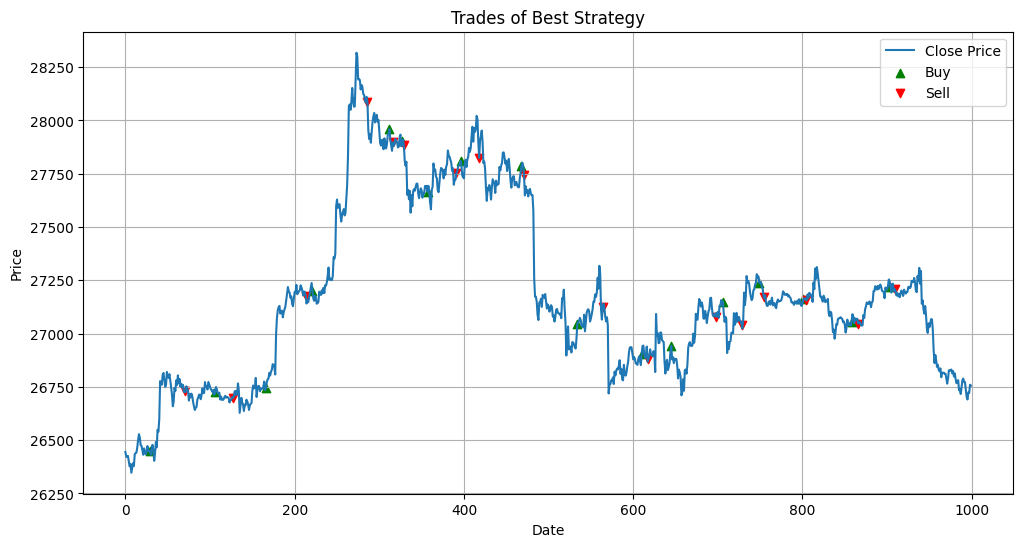

In [80]:
import matplotlib.pyplot as plt

# Retrieve the best strategy parameters
best_rsi_window, best_sma_window, best_rsi_threshold, _, _ = best_strategy

# Calculate RSI and SMA using the best strategy parameters
data['rsi'] = calculate_rsi(data, best_rsi_window)
data['sma'] = calculate_sma(data, best_sma_window)

# Initialize variables for tracking the positions
position = 0  # 0 for out of the market, 1 for long position
buy_points = []  # List to store the buy points
sell_points = []  # List to store the sell points

# Iterate over the data to identify the buy and sell points
for i in range(len(data)):
    # Check if the RSI is below the threshold and the close price is above the SMA
    if data['rsi'][i] < best_rsi_threshold and data['close'][i] > data['sma'][i]:
        # Enter a long position if not already in the market
        if position == 0:
            position = 1
            buy_points.append(i)
    # Check if the RSI is above the threshold and the close price is below the SMA
    elif data['rsi'][i] > best_rsi_threshold and data['close'][i] < data['sma'][i]:
        # Exit the long position if in the market
        if position == 1:
            position = 0
            sell_points.append(i)

# Plot the trades
plt.figure(figsize=(12, 6))
plt.plot(data['close'], label='Close Price')
plt.scatter(data.index[buy_points], data['close'].iloc[buy_points], marker='^', color='green', label='Buy')
plt.scatter(data.index[sell_points], data['close'].iloc[sell_points], marker='v', color='red', label='Sell')
plt.title('Trades of Best Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [86]:
# Retrieve the profits from the best strategy
best_profits = [result[3] for result in results_list]
total_trades = len(best_profits)

# Calculate the number of winning and losing trades for the best strategy
winning_trades = sum(profit > 0 for profit in best_profits)
losing_trades = sum(profit < 0 for profit in best_profits)

# Calculate the win rate
win_rate = winning_trades / (winning_trades + losing_trades) * 100

# Calculate the ratio of win rate to the buy and hold profit
win_rate_ratio = win_rate / (best_buy_hold_profit / data['close'].iloc[0])

# Print the win rate and win rate ratio
print("Win Rate: {:.2f}%".format(win_rate))
print("Win Rate Ratio: {:.2f}".format(win_rate_ratio))

# Retrieve the best strategy with the highest profit
best_strategy = results_list[0]
best_rsi_window, best_sma_window, best_rsi_threshold, best_profit, best_buy_hold_profit = best_strategy

# Print the best strategy
print("\nBest Strategy:")
print("RSI Window:", best_rsi_window)
print("SMA Window:", best_sma_window)
print("RSI Threshold:", best_rsi_threshold)
print("Profit:", best_profit)
print("Buy and Hold Profit:", best_buy_hold_profit)

# Calculate the number of winning and losing trades for the best strategy
winning_trades = sum(profit > 0 for profit in best_profits)
losing_trades = sum(profit < 0 for profit in best_profits)

# Calculate the win rate and win rate ratio
win_rate = winning_trades / total_trades
win_rate_ratio = winning_trades / losing_trades

# Calculate the additional statistics
total_trades = len(best_profits)
avg_profit_per_trade = sum(best_profits) / total_trades

drawdowns = [0]  # List to store drawdowns
peak = best_profit  # Initialize peak as the first profit
for profit in best_profits:
    if profit > peak:
        peak = profit
    drawdown = (peak - profit) / peak
    drawdowns.append(drawdown)
max_drawdown = max(drawdowns)

positive_profits = [profit for profit in best_profits if profit > 0]
negative_profits = [profit for profit in best_profits if profit < 0]
profit_factor = sum(positive_profits) / abs(sum(negative_profits))

average_win = sum(positive_profits) / len(positive_profits)
average_loss = abs(sum(negative_profits)) / len(negative_profits)
risk_reward_ratio = average_win / average_loss

# Print the results
print("\nBest Strategy Statistics:")
print("Strategy Parameters:")
print("RSI Window:", best_rsi_window)
print("SMA Window:", best_sma_window)
print("RSI Threshold:", best_rsi_threshold)
print("\nPerformance Statistics:")
print("Win Rate:", win_rate)
print("Win Rate Ratio:", win_rate_ratio)
print("Total Trades:", total_trades)
print("Average Profit per Trade:", avg_profit_per_trade)
print("Maximum Drawdown:", max_drawdown)
print("Profit Factor:", profit_factor)
print("Risk-Reward Ratio:", risk_reward_ratio)


Win Rate: 50.98%
Win Rate Ratio: 4337.56

Best Strategy:
RSI Window: 15
SMA Window: 25
RSI Threshold: 50
Profit: 1548.7600000000057
Buy and Hold Profit: 310.8099999999977

Best Strategy Statistics:
Strategy Parameters:
RSI Window: 15
SMA Window: 25
RSI Threshold: 50

Performance Statistics:
Win Rate: 0.24118738404452691
Win Rate Ratio: 1.04
Total Trades: 1617
Average Profit per Trade: 88.39823747680863
Maximum Drawdown: 1.869702213383604
Profit Factor: 3.2756007562625897
Risk-Reward Ratio: 3.149616111790952


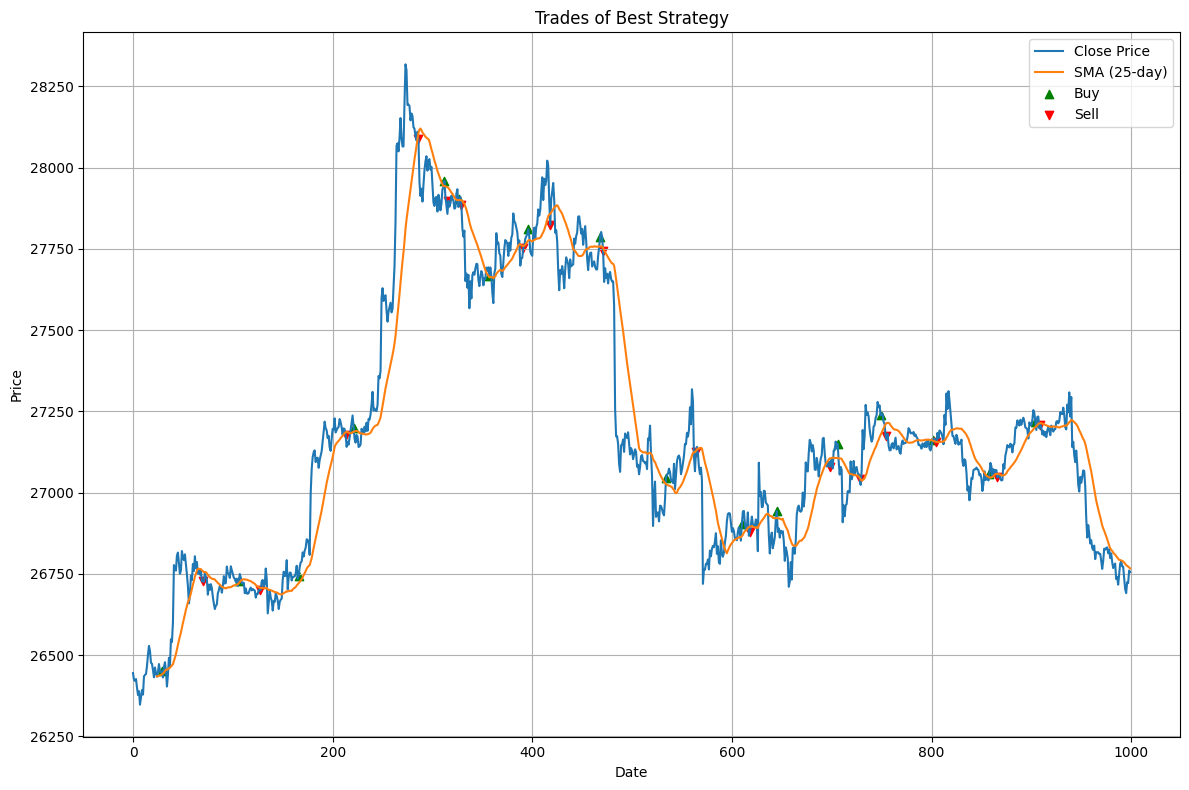

In [81]:
import matplotlib.pyplot as plt

# Retrieve the best strategy parameters
best_rsi_window, best_sma_window, best_rsi_threshold, _, _ = best_strategy

# Calculate RSI and SMA using the best strategy parameters
data['rsi'] = calculate_rsi(data, best_rsi_window)
data['sma'] = calculate_sma(data, best_sma_window)

# Initialize variables for tracking the positions
position = 0  # 0 for out of the market, 1 for long position
buy_points = []  # List to store the buy points
sell_points = []  # List to store the sell points

# Iterate over the data to identify the buy and sell points
for i in range(len(data)):
    # Check if the RSI is below the threshold and the close price is above the SMA
    if data['rsi'][i] < best_rsi_threshold and data['close'][i] > data['sma'][i]:
        # Enter a long position if not already in the market
        if position == 0:
            position = 1
            buy_points.append(i)
    # Check if the RSI is above the threshold and the close price is below the SMA
    elif data['rsi'][i] > best_rsi_threshold and data['close'][i] < data['sma'][i]:
        # Exit the long position if in the market
        if position == 1:
            position = 0
            sell_points.append(i)

# Plot the main graph with SMA, RSI, and trade signals
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the close price
ax.plot(data['close'], label='Close Price')

# Plot the SMA
ax.plot(data['sma'], label='SMA ({}-day)'.format(best_sma_window))

# Plot the buy and sell signals
ax.scatter(data.index[buy_points], data['close'].iloc[buy_points], marker='^', color='green', label='Buy')
ax.scatter(data.index[sell_points], data['close'].iloc[sell_points], marker='v', color='red', label='Sell')

ax.set_title('Trades of Best Strategy')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


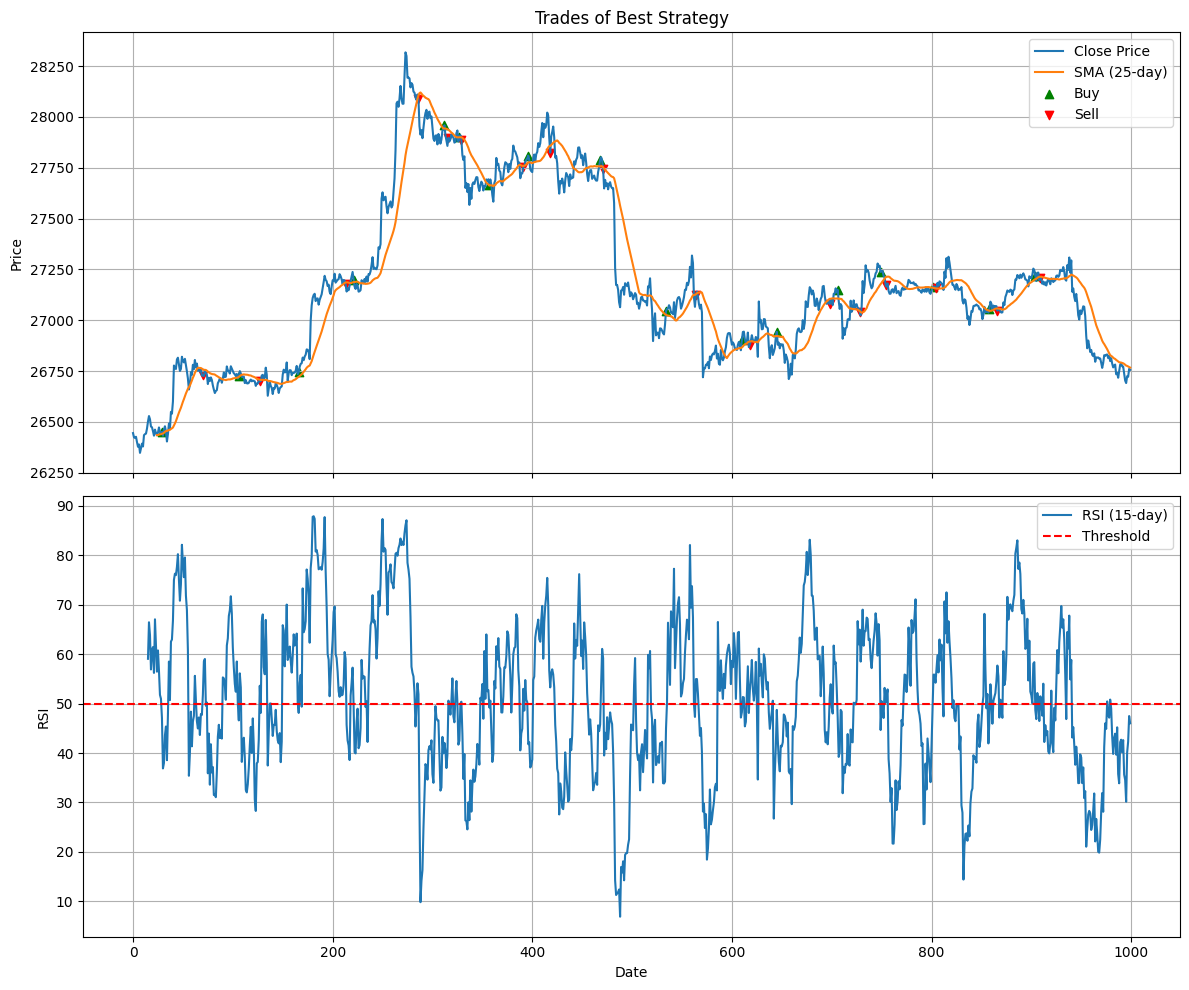

In [82]:
import matplotlib.pyplot as plt

# Retrieve the best strategy parameters
best_rsi_window, best_sma_window, best_rsi_threshold, _, _ = best_strategy

# Calculate RSI and SMA using the best strategy parameters
data['rsi'] = calculate_rsi(data, best_rsi_window)
data['sma'] = calculate_sma(data, best_sma_window)

# Initialize variables for tracking the positions
position = 0  # 0 for out of the market, 1 for long position
buy_points = []  # List to store the buy points
sell_points = []  # List to store the sell points

# Iterate over the data to identify the buy and sell points
for i in range(len(data)):
    # Check if the RSI is below the threshold and the close price is above the SMA
    if data['rsi'][i] < best_rsi_threshold and data['close'][i] > data['sma'][i]:
        # Enter a long position if not already in the market
        if position == 0:
            position = 1
            buy_points.append(i)
    # Check if the RSI is above the threshold and the close price is below the SMA
    elif data['rsi'][i] > best_rsi_threshold and data['close'][i] < data['sma'][i]:
        # Exit the long position if in the market
        if position == 1:
            position = 0
            sell_points.append(i)

# Plot the main graph with SMA and trade signals
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plot the close price and SMA on the upper chart
ax1.plot(data['close'], label='Close Price')
ax1.plot(data['sma'], label='SMA ({}-day)'.format(best_sma_window))
ax1.scatter(data.index[buy_points], data['close'].iloc[buy_points], marker='^', color='green', label='Buy')
ax1.scatter(data.index[sell_points], data['close'].iloc[sell_points], marker='v', color='red', label='Sell')
ax1.set_title('Trades of Best Strategy')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# Plot the RSI on the lower chart
ax2.plot(data['rsi'], label='RSI ({}-day)'.format(best_rsi_window))
ax2.axhline(y=best_rsi_threshold, color='red', linestyle='--', label='Threshold')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


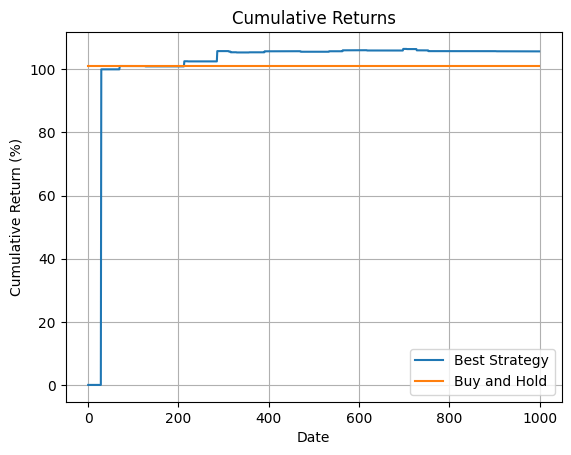

In [83]:
import matplotlib.pyplot as plt

# Retrieve the best strategy parameters
best_rsi_window, best_sma_window, best_rsi_threshold, _, _ = best_strategy

# Calculate RSI and SMA using the best strategy parameters
data['rsi'] = calculate_rsi(data, best_rsi_window)
data['sma'] = calculate_sma(data, best_sma_window)

# Initialize variables for tracking the positions and profits
position = 0  # 0 for out of the market, 1 for long position
buy_price = 0  # Price at which the position was opened
best_profit = 0  # Accumulated profit for the best strategy
buy_hold_profit = data['close'].iloc[-1] - data['close'].iloc[0]  # Buy and hold profit
best_cumulative_returns = []
buy_hold_cumulative_returns = []

# Iterate over the data
for i in range(len(data)):
    # Check if the RSI is below the threshold and the close price is above the SMA
    if data['rsi'][i] < best_rsi_threshold and data['close'][i] > data['sma'][i]:
        # Enter a long position if not already in the market
        if position == 0:
            position = 1
            buy_price = data['close'][i]
    # Check if the RSI is above the threshold and the close price is below the SMA
    elif data['rsi'][i] > best_rsi_threshold and data['close'][i] < data['sma'][i]:
        # Exit the long position if in the market
        if position == 1:
            position = 0
            sell_price = data['close'][i]
            best_profit += sell_price - buy_price  # Update the profit

    # Calculate the cumulative returns for the best strategy and buy and hold strategy
    if buy_price != 0:
        best_cumulative_return = (1 + best_profit / buy_price) * 100
    else:
        best_cumulative_return = 0  # No trades executed by the best strategy
    buy_hold_cumulative_return = (1 + buy_hold_profit / data['close'].iloc[0]) * 100

    best_cumulative_returns.append(best_cumulative_return)
    buy_hold_cumulative_returns.append(buy_hold_cumulative_return)

# Plot the cumulative returns of the best strategy and buy and hold strategy
plt.plot(data.index, best_cumulative_returns, label='Best Strategy')
plt.plot(data.index, buy_hold_cumulative_returns, label='Buy and Hold')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.show()
